<a href="https://colab.research.google.com/github/marcin21040/Big_Data/blob/main/Big_data_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install river

In [28]:
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    LabelEncoder, OneHotEncoder
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)

from river import preprocessing, linear_model, metrics, drift


In [29]:
# Remove columns that are completely empty
# Data cleaning, imputation, scaling and low-variance filtering
# Full preprocessing pipeline (cleaning, scaling, encoding)
# Merge clinical and genetic data
# Load genetic data
# Load clinical data

class DataProcessor:
    def __init__(self, impute_strategy='mean', scale_method='standard', knn_k=5,
                 drop_thresh_cols=None, drop_thresh_rows=None):
        self.impute_strategy = impute_strategy
        self.scale_method = scale_method
        self.knn_k = knn_k
        self.drop_thresh_cols = drop_thresh_cols
        self.drop_thresh_rows = drop_thresh_rows
        self.scalers = {
            'standard': StandardScaler(),
            'minmax': MinMaxScaler(),
            'robust': RobustScaler()
        }

    def load_clinical(self, path: str) -> pd.DataFrame:
        df = pd.read_csv(path, sep='\t', skiprows=4)
        df.columns = df.columns.str.lstrip('#').str.strip()
        df = df.drop(columns=['Other Patient ID'], errors='ignore')
        pid = [c for c in df.columns if re.match(r'(?i)patient[ _]?id$', c)]
        df = df.rename(columns={pid[0]: 'Patient_ID'}).set_index('Patient_ID')
        return df

    def load_genetic(self, path: str) -> pd.DataFrame:
        df = pd.read_csv(path, sep='\t')
        df = df.drop(columns=['Entrez_Gene_Id'], errors='ignore')
        df = df.set_index('Hugo_Symbol').T
        df.index = df.index.str.replace(r'-\d+$', '', regex=True)
        df.index.name = 'Patient_ID'
        return df

    def integrate(self, clin: pd.DataFrame, gen: pd.DataFrame, how='inner') -> pd.DataFrame:
        merged = clin.join(gen, how=how)
        print(f"Integrated: {merged.shape[0]} patients, {merged.shape[1]} features")
        display(merged.head())
        return merged

    def prepare(self, clinical_path, genetic_path, target,
                use_clean=True):

        clin = self.load_clinical(clinical_path)
        gen = self.load_genetic(genetic_path)
        df = self.integrate(clin, gen)

        if target not in df.columns:
            raise ValueError(f"Target column '{target}' not found in merged data.")

        if use_clean:
            df = self.clean_scale(df)

        if target not in df.columns:
            raise ValueError(f"Target column '{target}' not found after cleaning.")

        y = df[target]
        X = df.drop(columns=[target])

        if y.dtype == 'object' or y.dtype.name == 'category':
            y = LabelEncoder().fit_transform(y)

        return X, y

    def clean_scale(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()


        df = self.remove_empty_columns(df)

        if self.drop_thresh_cols is not None:
            df = df.loc[:, df.isna().mean() <= self.drop_thresh_cols]
        if self.drop_thresh_rows is not None:
            df = df.loc[df.isna().mean(axis=1) <= self.drop_thresh_rows]


        if self.impute_strategy in ('mean', 'median', 'most_frequent'):
            imputer = SimpleImputer(strategy=self.impute_strategy)
        else:
            imputer = KNNImputer(n_neighbors=self.knn_k)

        nums = df.select_dtypes(include='number').columns
        df[nums] = imputer.fit_transform(df[nums])


        scaler = self.scalers[self.scale_method]
        df[nums] = scaler.fit_transform(df[nums])


        selector = VarianceThreshold(threshold=0.01)
        reduced_array = selector.fit_transform(df[nums])
        kept_cols = nums[selector.get_support()]
        df_reduced = pd.DataFrame(reduced_array, columns=kept_cols, index=df.index)


        df_final = df.drop(columns=nums).join(df_reduced)

        return df_final

    @staticmethod
    def remove_empty_columns(df: pd.DataFrame) -> pd.DataFrame:

        df_clean = df.dropna(axis=1, how='all')
        return df_clean


In [30]:
# Full preprocessing pipeline (cleaning, scaling, encoding)

class ModelTrainer:
    def __init__(self, strategy='in_memory'):
        self.strategy = strategy
        self.label_enc = LabelEncoder()
        self.model = None
        self.scaler = None


        self.processor = DataProcessor()

    def prepare(self, clinical_path, genetic_path, target, use_clean=False, **proc_kwargs):
        dp = DataProcessor(**proc_kwargs)
        X, y = dp.prepare(clinical_path, genetic_path, target, use_clean=use_clean)


        self.label_enc = LabelEncoder().fit(y)
        y_encoded = self.label_enc.transform(y)

        if self.strategy == 'in_memory':
            return train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

        elif self.strategy == 'streaming':

            y_decoded = self.label_enc.inverse_transform(y_encoded)

            df = X.copy()
            df[target] = y_decoded

            csv_path = 'merged_stream.csv'
            df.to_csv(csv_path, index=False)
            return csv_path, target

        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

    def train(self, X_train=None, y_train=None, X_test=None, y_test=None, data_path=None, target=None, param_grids=None, chunksize=1000):
        results = {}

        if self.strategy == 'in_memory':

            models = {'LR': LogisticRegression(max_iter=1000)}
            param_grids = param_grids or {'LR': {'C': [0.1, 1, 10]}}
            for name, mdl in models.items():
                gs = GridSearchCV(mdl, param_grids[name], cv=5,
                                  scoring='f1', n_jobs=-1)
                gs.fit(X_train, y_train)
                best = gs.best_estimator_
                p = best.predict(X_test)
                results[name] = {
                    'params': gs.best_params_,
                    'metrics': {
                        'acc':  accuracy_score(y_test, p),
                        'prec': precision_score(y_test, p, zero_division=0),
                        'rec':  recall_score(y_test, p, zero_division=0),
                        'f1':   f1_score(y_test, p, zero_division=0)
                    },
                    'model': best
                }

        elif self.strategy == 'streaming':

            all_classes = pd.read_csv(data_path, usecols=[target])[target] \
                            .dropna().unique()
            self.label_enc = LabelEncoder().fit(all_classes)
            classes_int = self.label_enc.transform(all_classes)


            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(strategy='mean')
            self.scaler = StandardScaler()
            self.model = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True)

            first_chunk = True
            last_Xc, last_yc = None, None


            for chunk in pd.read_csv(data_path, chunksize=chunksize, low_memory=False):
                chunk = self.processor.remove_empty_columns(chunk)
                chunk = chunk.dropna(subset=[target])
                if chunk.empty:
                    continue

                Xc = chunk.drop(columns=[target]).select_dtypes(include=[np.number])
                yc = self.label_enc.transform(chunk[target])

                if first_chunk:
                    Xc = imputer.fit_transform(Xc)
                    Xc = self.scaler.fit_transform(Xc)
                    self.model.partial_fit(Xc, yc, classes=classes_int)
                    first_chunk = False
                else:
                    Xc = imputer.transform(Xc)
                    Xc = self.scaler.transform(Xc)
                    self.model.partial_fit(Xc, yc)

                last_Xc, last_yc = Xc, yc

            if last_Xc is None:
                raise ValueError("Brak niepustych batchy – sprawdź dane.")
            y_pred = self.model.predict(last_Xc)
            results['SGD_stream'] = {
                'params': {},
                'metrics': {
                    'acc':  accuracy_score(last_yc, y_pred),
                    'prec': precision_score(last_yc, y_pred, average='weighted', zero_division=0),
                    'rec':  recall_score(last_yc, y_pred, average='weighted', zero_division=0),
                    'f1':   f1_score(last_yc, y_pred, average='weighted', zero_division=0)
                },
                'model': self.model
            }


        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")

        return results

In [31]:
# Model evaluation and visualization utilities
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)

class ModelEvaluator:
    def __init__(self, results):
        self.results = results

    def report(self):
        for name, r in self.results.items():
            m = r['metrics']
            print(f"{name}: ACC={m['acc']:.3f}, PREC={m['prec']:.3f}, REC={m['rec']:.3f}, F1={m['f1']:.3f}")

    def plot_roc(self, X_test, y_test):
        if len(np.unique(y_test)) > 2:
            print("Krzywa ROC dotyczy tylko klasyfikacji binarnej.")
            return

        plt.figure(figsize=(8, 6))
        for name, r in self.results.items():
            prob = r['model'].predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, prob)
            auc = roc_auc_score(y_test, prob)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curves')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
        for name, r in self.results.items():
            y_pred = r['model'].predict(X_test)
            disp = ConfusionMatrixDisplay.from_predictions(
                y_test, y_pred, cmap='Blues', normalize='true')
            disp.ax_.set_title(f"Macierz pomyłek: {name}")
            plt.tight_layout()
            plt.show()

    def plot_metrics_comparison(self):
        metrics = ['acc', 'prec', 'rec', 'f1']
        data = {m: [] for m in metrics}
        labels = []

        for name, r in self.results.items():
            labels.append(name)
            for m in metrics:
                data[m].append(r['metrics'][m])

        x = np.arange(len(labels))
        width = 0.2

        plt.figure(figsize=(10, 6))
        for i, m in enumerate(metrics):
            plt.bar(x + i * width, data[m], width, label=m.upper())

        plt.xticks(x + width * 1.5, labels)
        plt.ylabel('Wartość metryki')
        plt.title('Porównanie metryk modeli')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_class_distribution(self, y):
        sns.countplot(x=y)
        plt.title("Rozkład klas")
        plt.show()

    def plot_missing_values(self, df):
        missing = df.isnull().mean() * 100
        missing = missing[missing > 0].sort_values()
        missing.plot(kind='barh', figsize=(10, 6))
        plt.xlabel('Procent braków')
        plt.title('Braki danych w cechach')
        plt.tight_layout()
        plt.show()


In [32]:
# Train and evaluate classification models on cleaned and scaled clinical-genetic data
trainer = ModelTrainer(strategy='in_memory')

X_train, X_test, y_train, y_test = trainer.prepare(
    clinical_path='data_clinical_patient.txt',
    genetic_path='data_genetic.txt',
    target='SEX',
    impute_strategy='mean',
    scale_method='standard',
    drop_thresh_cols=0.1,
    drop_thresh_rows=0.1,
    use_clean=True
)
X_train = X_train.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])
X_train = X_train.iloc[:, :200]
X_test = X_test.iloc[:, :200]

results = trainer.train(X_train, y_train, X_test, y_test)
evaluator = ModelEvaluator(results)
evaluator.report()

Integrated: 375 patients, 20519 features


,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,DAYS_TO_BIRTH,SEX,HEIGHT,WEIGHT,RACE,ETHNICITY,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KP,65D1EAEC-28DB-4A41-A4DB-1A710FCB24AD,2014-3-19,NO,YES,-24428,Male,186,130,WHITE,NOT HISPANIC OR LATINO,...,"37,037","316,6875","1420,7241","17,062","1526,4253","3105,2851","1467,7486","860,5909","2,913",0
TCGA-2F-A9KQ,25EAF3F9-C364-423C-AAAE-925E7B393AFC,2014-3-19,NO,YES,-25259,Male,168,72,WHITE,NOT HISPANIC OR LATINO,...,"60,2689","378,3032","873,4353","1,8544","1571,1637","3275,3825","750,5795","621,2332","3,2452","0,4636"
TCGA-2F-A9KR,F6D916B0-8E4C-49CB-A0D4-883908F3284F,2014-3-19,NO,YES,-21848,Female,176,80,[Not Available],[Not Available],...,"45,5869","470,115","1924,1476","1,8995","748,86","4465,6181","910,7885","935,4815","366,1199",0
TCGA-2F-A9KT,BC6C516B-591E-4950-B6B0-DECAFA666F4E,2014-3-19,NO,YES,-30520,Male,180,80,WHITE,NOT HISPANIC OR LATINO,...,"17,524","281,515","938,3833","6,7835","878,4624","3449,4064","850,1979","630,8649","10,1752",0
TCGA-2F-A9KW,3B464065-B2E9-4FB2-A7DA-09E963FD43B3,2014-3-19,YES,NO,-24703,Female,167,70,WHITE,NOT HISPANIC OR LATINO,...,"25,6571","244,0046","1160,3309","51,3143","1493,8737","2778,3014","2811,2891","746,1514","16,7557",0


LR: ACC=0.734, PREC=0.734, REC=1.000, F1=0.847


In [33]:
# Train and evaluate models on large dataset using streaming (chunk-wise) approach
trainer = ModelTrainer(strategy='streaming')

data_path, target = trainer.prepare(
    clinical_path='data_clinical_patient.txt',
    genetic_path='data_genetic.txt',
    target='SEX',
    use_clean=False
)


results = trainer.train(
    data_path=data_path,
    target=target,
    chunksize=500
)

evaluator = ModelEvaluator(results)
evaluator.report()



Integrated: 375 patients, 20519 features


,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,DAYS_TO_BIRTH,SEX,HEIGHT,WEIGHT,RACE,ETHNICITY,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KP,65D1EAEC-28DB-4A41-A4DB-1A710FCB24AD,2014-3-19,NO,YES,-24428,Male,186,130,WHITE,NOT HISPANIC OR LATINO,...,"37,037","316,6875","1420,7241","17,062","1526,4253","3105,2851","1467,7486","860,5909","2,913",0
TCGA-2F-A9KQ,25EAF3F9-C364-423C-AAAE-925E7B393AFC,2014-3-19,NO,YES,-25259,Male,168,72,WHITE,NOT HISPANIC OR LATINO,...,"60,2689","378,3032","873,4353","1,8544","1571,1637","3275,3825","750,5795","621,2332","3,2452","0,4636"
TCGA-2F-A9KR,F6D916B0-8E4C-49CB-A0D4-883908F3284F,2014-3-19,NO,YES,-21848,Female,176,80,[Not Available],[Not Available],...,"45,5869","470,115","1924,1476","1,8995","748,86","4465,6181","910,7885","935,4815","366,1199",0
TCGA-2F-A9KT,BC6C516B-591E-4950-B6B0-DECAFA666F4E,2014-3-19,NO,YES,-30520,Male,180,80,WHITE,NOT HISPANIC OR LATINO,...,"17,524","281,515","938,3833","6,7835","878,4624","3449,4064","850,1979","630,8649","10,1752",0
TCGA-2F-A9KW,3B464065-B2E9-4FB2-A7DA-09E963FD43B3,2014-3-19,YES,NO,-24703,Female,167,70,WHITE,NOT HISPANIC OR LATINO,...,"25,6571","244,0046","1160,3309","51,3143","1493,8737","2778,3014","2811,2891","746,1514","16,7557",0


SGD_stream: ACC=0.701, PREC=0.620, REC=0.701, F1=0.638


In [34]:
# Online training with concept drift detection and automatic model reset using ADWIN
class DriftTrainer:
    def __init__(self):
        self.numeric_cols = None
        self.model = preprocessing.StandardScaler() | linear_model.LogisticRegression()
        self.drift_detector = drift.ADWIN()
        self.metric = metrics.F1()
        self.min_samples_drift = 200
        self.errors_seen = 0
        self.label_enc = LabelEncoder()
        self.label_fitted = False

    def train_on_stream(self, data_path, target, chunksize=1000):
        for chunk in pd.read_csv(data_path, chunksize=chunksize, low_memory=False):
            if self.numeric_cols is None:
                self.numeric_cols = chunk.select_dtypes(include=[np.number]).columns.tolist()
            if not self.label_fitted:
                labels = chunk[target].dropna().unique()
                self.label_enc.fit(labels)
                self.label_fitted = True
            for _, row in chunk.iterrows():
                y = row[target]
                if pd.isna(y):
                    continue
                y = self.label_enc.transform([y])[0]

                x = {col: row[col] if not pd.isna(row[col]) else 0
                     for col in self.numeric_cols}
                y_pred = self.model.predict_one(x)
                self.metric.update(y, y_pred)
                error = int(y_pred != y)
                if self.errors_seen >= self.min_samples_drift:
                    self.drift_detector.update(error)
                if self.drift_detector.drift_detected:
                    print(f"Drift at sample {self.errors_seen} → reset")
                    self.model = preprocessing.StandardScaler() | linear_model.LogisticRegression()
                    self.metric = metrics.F1()
                    self.drift_detector = drift.ADWIN()
                    self.errors_seen = 0
                    continue
                self.model.learn_one(x, y)
                self.errors_seen += 1
            print(f"After batch, F1 = {self.metric.get():.3f}")
        return self.metric.get()


drift_trainer = DriftTrainer()
final_f1 = drift_trainer.train_on_stream(
    data_path=data_path,
    target=target,
    chunksize=500
)
print(f"\n==> Final F1 after streaming with drift handling: {final_f1:.3f}")



After batch, F1 = 0.998

==> Final F1 after streaming with drift handling: 0.998


In [35]:
# Data perturbation and robustness testing using multiple modified datasets

import pandas as pd
import numpy as np
import random

DATA = pd.read_csv("merged_stream.csv")

def modify_numeric(df, percentage=0.02, operation='sub', drop_rows=0.0, drop_cols=0.0):
    df_mod = df.copy()

    num_cols = df_mod.select_dtypes(include=[np.number]).columns
    other_cols = df_mod.columns.difference(num_cols)

    for col in num_cols:
        noise = np.random.uniform(0, percentage, size=len(df_mod)) * df_mod[col]
        if operation == 'sub':
            df_mod[col] = df_mod[col] - noise
        elif operation == 'add':
            df_mod[col] = df_mod[col] + noise

    if drop_rows > 0:
        df_mod = df_mod.drop(df_mod.sample(frac=drop_rows, random_state=42).index)

    if drop_cols > 0:
        cols_to_remove = random.sample(list(num_cols), int(len(num_cols) * drop_cols))
        df_mod = df_mod.drop(columns=cols_to_remove)

    return df_mod

DATA = DATA.copy()

DATA_A = modify_numeric(DATA, percentage=0.02, operation='sub')

DATA_B = modify_numeric(DATA, percentage=0.03, operation='add', drop_rows=0.05)

DATA_C = modify_numeric(DATA, percentage=0.03, operation='add', drop_cols=0.2)

DATA.to_csv("DATA.csv", index=False)
DATA_A.to_csv("DATA_A.csv", index=False)
DATA_B.to_csv("DATA_B.csv", index=False)
DATA_C.to_csv("DATA_C.csv", index=False)


trainer = ModelTrainer(strategy='streaming')

for name, path in zip(['DATA', 'DATA_A', 'DATA_B', 'DATA_C'],
                      ['DATA.csv', 'DATA_A.csv', 'DATA_B.csv', 'DATA_C.csv']):
    print(f"\n Trening na paczce {name}...")
    results = trainer.train(data_path=path, target='SEX', chunksize=1000)
    print(f" Wyniki dla {name}:")
    print(results['SGD_stream']['metrics'])


<ipython-input-35-1616073371>:7: DtypeWarning: Columns (4,5,6,27,37,39,78,85,91,93,155,240,290,293,307,310,326,337,355,358,359,361,567,660,686,776,856,928,1152,1156,1158,1159,1252,1275,1356,1363,1380,1451,1460,1537,1565,1574,1592,1609,1649,1653,1696,1757,1758,1774,1788,1801,1816,1832,1853,1858,1910,1947,1954,1976,1979,1995,2004,2047,2066,2129,2141,2156,2191,2217,2268,2323,2358,2383,2385,2397,2404,2421,2436,2442,2460,2476,2480,2513,2524,2557,2571,2574,2586,2592,2597,2632,2668,2762,2767,2796,2807,2848,2897,2911,2913,2936,3041,3124,3189,3394,3582,3583,3584,3585,3589,3614,3615,3616,3681,3687,3691,3694,3805,3899,3976,3977,4018,4339,4340,4366,4368,4373,4374,4375,4376,4389,4408,4418,4425,4426,4428,4429,4430,4431,4432,4433,4470,4485,4550,4564,4572,4596,4597,4601,4602,4692,4706,4707,4708,4724,4751,4793,4857,4860,4862,4865,4866,4873,4874,4876,4877,4879,4881,4882,4883,4885,4886,4889,4970,5021,5027,5084,5121,5178,5232,5234,5259,5324,5369,5418,5544,5601,5817,5875,5879,5888,5981,5982,6075,6080,6101,


 Trening na paczce DATA...
 Wyniki dla DATA:
{'acc': 0.7333333333333333, 'prec': 0.5377777777777778, 'rec': 0.7333333333333333, 'f1': 0.6205128205128205}

 Trening na paczce DATA_A...
 Wyniki dla DATA_A:
{'acc': 0.005333333333333333, 'prec': 4.139528151686206e-05, 'rec': 0.005333333333333333, 'f1': 8.209074875741543e-05}

 Trening na paczce DATA_B...
 Wyniki dla DATA_B:
{'acc': 0.23314606741573032, 'prec': 0.0751074579594299, 'rec': 0.23314606741573032, 'f1': 0.11361432726857924}

 Trening na paczce DATA_C...
 Wyniki dla DATA_C:
{'acc': 0.18133333333333335, 'prec': 0.07462277091906722, 'rec': 0.18133333333333335, 'f1': 0.10573372206025268}



 Strategia: IN_MEMORY
Integrated: 375 patients, 20519 features


,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,DAYS_TO_BIRTH,SEX,HEIGHT,WEIGHT,RACE,ETHNICITY,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KP,65D1EAEC-28DB-4A41-A4DB-1A710FCB24AD,2014-3-19,NO,YES,-24428,Male,186,130,WHITE,NOT HISPANIC OR LATINO,...,"37,037","316,6875","1420,7241","17,062","1526,4253","3105,2851","1467,7486","860,5909","2,913",0
TCGA-2F-A9KQ,25EAF3F9-C364-423C-AAAE-925E7B393AFC,2014-3-19,NO,YES,-25259,Male,168,72,WHITE,NOT HISPANIC OR LATINO,...,"60,2689","378,3032","873,4353","1,8544","1571,1637","3275,3825","750,5795","621,2332","3,2452","0,4636"
TCGA-2F-A9KR,F6D916B0-8E4C-49CB-A0D4-883908F3284F,2014-3-19,NO,YES,-21848,Female,176,80,[Not Available],[Not Available],...,"45,5869","470,115","1924,1476","1,8995","748,86","4465,6181","910,7885","935,4815","366,1199",0
TCGA-2F-A9KT,BC6C516B-591E-4950-B6B0-DECAFA666F4E,2014-3-19,NO,YES,-30520,Male,180,80,WHITE,NOT HISPANIC OR LATINO,...,"17,524","281,515","938,3833","6,7835","878,4624","3449,4064","850,1979","630,8649","10,1752",0
TCGA-2F-A9KW,3B464065-B2E9-4FB2-A7DA-09E963FD43B3,2014-3-19,YES,NO,-24703,Female,167,70,WHITE,NOT HISPANIC OR LATINO,...,"25,6571","244,0046","1160,3309","51,3143","1493,8737","2778,3014","2811,2891","746,1514","16,7557",0


LR: ACC=0.734, PREC=0.734, REC=1.000, F1=0.847


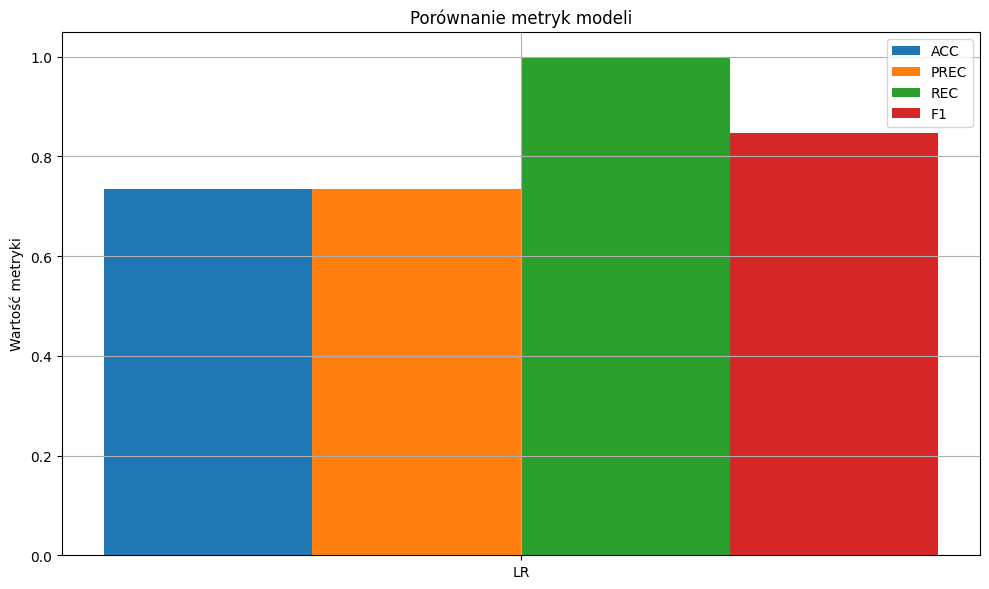


 Strategia: STREAMING
Integrated: 375 patients, 20519 features


,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,DAYS_TO_BIRTH,SEX,HEIGHT,WEIGHT,RACE,ETHNICITY,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KP,65D1EAEC-28DB-4A41-A4DB-1A710FCB24AD,2014-3-19,NO,YES,-24428,Male,186,130,WHITE,NOT HISPANIC OR LATINO,...,"37,037","316,6875","1420,7241","17,062","1526,4253","3105,2851","1467,7486","860,5909","2,913",0
TCGA-2F-A9KQ,25EAF3F9-C364-423C-AAAE-925E7B393AFC,2014-3-19,NO,YES,-25259,Male,168,72,WHITE,NOT HISPANIC OR LATINO,...,"60,2689","378,3032","873,4353","1,8544","1571,1637","3275,3825","750,5795","621,2332","3,2452","0,4636"
TCGA-2F-A9KR,F6D916B0-8E4C-49CB-A0D4-883908F3284F,2014-3-19,NO,YES,-21848,Female,176,80,[Not Available],[Not Available],...,"45,5869","470,115","1924,1476","1,8995","748,86","4465,6181","910,7885","935,4815","366,1199",0
TCGA-2F-A9KT,BC6C516B-591E-4950-B6B0-DECAFA666F4E,2014-3-19,NO,YES,-30520,Male,180,80,WHITE,NOT HISPANIC OR LATINO,...,"17,524","281,515","938,3833","6,7835","878,4624","3449,4064","850,1979","630,8649","10,1752",0
TCGA-2F-A9KW,3B464065-B2E9-4FB2-A7DA-09E963FD43B3,2014-3-19,YES,NO,-24703,Female,167,70,WHITE,NOT HISPANIC OR LATINO,...,"25,6571","244,0046","1160,3309","51,3143","1493,8737","2778,3014","2811,2891","746,1514","16,7557",0


SGD_stream: ACC=0.733, PREC=0.538, REC=0.733, F1=0.621


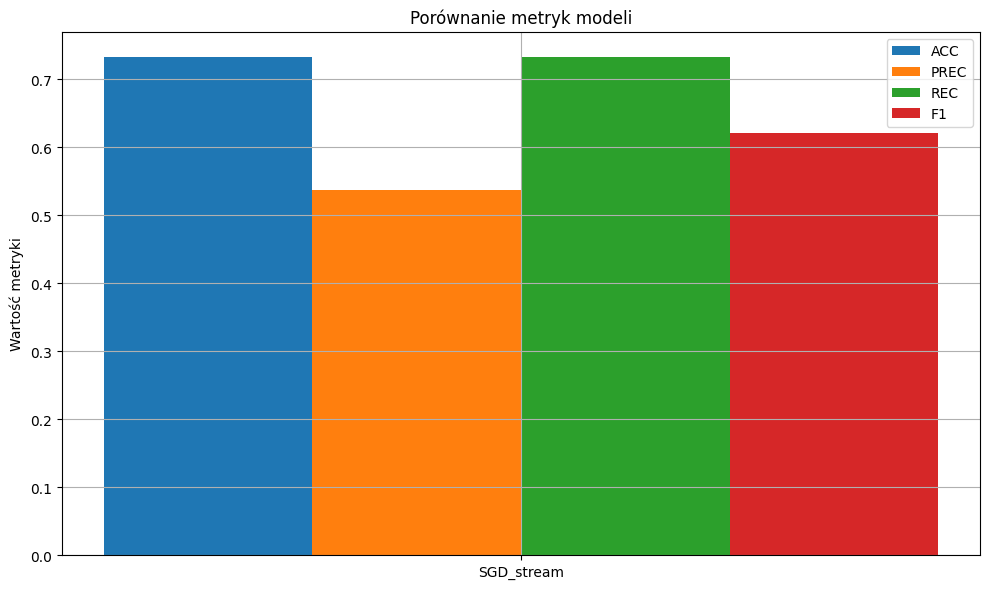


 Strategia: DRIFT_AWARE (streaming z detekcją dryfu)
After batch, F1 = 0.998
 Final F1 with drift handling: 0.998

 Wszystkie strategie przetworzone.


In [36]:
def main_pipeline():
    clinical_path = 'data_clinical_patient.txt'
    genetic_path = 'data_genetic.txt'
    target_column = 'SEX'

    print("\n Strategia: IN_MEMORY")
    trainer = ModelTrainer(strategy='in_memory')
    X_train, X_test, y_train, y_test = trainer.prepare(
        clinical_path=clinical_path,
        genetic_path=genetic_path,
        target=target_column,
        impute_strategy='mean',
        scale_method='standard',
        drop_thresh_cols=0.1,
        drop_thresh_rows=0.1,
        use_clean=True
    )
    X_train = X_train.select_dtypes(include=[np.number]).iloc[:, :200]
    X_test = X_test.select_dtypes(include=[np.number]).iloc[:, :200]

    results = trainer.train(X_train, y_train, X_test, y_test)
    evaluator = ModelEvaluator(results)
    evaluator.report()
    evaluator.plot_metrics_comparison()

    print("\n Strategia: STREAMING")
    trainer = ModelTrainer(strategy='streaming')
    data_path, target = trainer.prepare(
        clinical_path=clinical_path,
        genetic_path=genetic_path,
        target=target_column,
        use_clean=False
    )
    results = trainer.train(data_path=data_path, target=target, chunksize=500)
    evaluator = ModelEvaluator(results)
    evaluator.report()
    evaluator.plot_metrics_comparison()

    print("\n Strategia: DRIFT_AWARE (streaming z detekcją dryfu)")
    drift_trainer = DriftTrainer()
    final_f1 = drift_trainer.train_on_stream(
        data_path=data_path,
        target=target,
        chunksize=500
    )
    print(f" Final F1 with drift handling: {final_f1:.3f}")

    print("\n Wszystkie strategie przetworzone.")

main_pipeline()
